# Simple Atom Analysis Notebook

#### This notebook is designed to replicate the Mathematica "Single_Atom" Notebook. This notebook makes heavy use of the "dataAnalysisFunctions" module that I created.

### Imports

In [71]:
### Uninteresting stuff.
# show plots in this notebook. "magic" command.
%matplotlib inline
# Data is saved as "data_#.fits" files
from astropy.io import fits
import numpy
numpy.set_printoptions(threshold=numpy.nan)
from matplotlib.pyplot import figure, hist, plot, title, xlabel, ylabel, subplots, errorbar, gcf
from matplotlib.cm import get_cmap
from dataAnalysisFunctions import (normalizeData, binData, guessGaussianPeaks, doubleGaussian, fitDoubleGaussian, 
                                   calculateAtomThreshold, getAnalyzedSurvivalData);

### Initialize Constants

In [72]:
#
date = "160618";
fileName = "Ramsey_Piezo_Scan_Top_Y";
runNumber = 17;
wellIndicator = 6;
accumulations = 150;
### Zero-indexed!!!

# Vertical
# atomLocation = [1,wellIndicator-1];
# Horizontal
atomLocation = [wellIndicator-1, 1];

picturesPerExperiment = 2;
#atomPeakGuess = 400;

In [73]:
#
dataRepositoryPath = "\\\\andor\\share\\Data and documents\\Data repository\\";
todaysDataPath = dataRepositoryPath + date + "\\data_" + str(runNumber) + ".fits";
print(todaysDataPath)
keyPath = dataRepositoryPath + date + "\\key_" + str(runNumber) + ".txt";
#todaysDataPath = dataRepositoryPath + date + "\\data.fits";
#keyPath = dataRepositoryPath + "Key_file\\key.txt"

\\andor\share\Data and documents\Data repository\160618\data_17.fits


### Load Key File

In [74]:
#
key = numpy.array([]);
with open(keyPath) as keyFile:
    for line in keyFile:
        key = numpy.append(key, float(line.strip('\n')))

### Load Fits File & Get Dimensions

In [75]:
# Get the array from the fits file. That's all I care about.
print(todaysDataPath)
fitsInfo = (fits.open(todaysDataPath, "append"));
fitsInfo.info();
rawData = fitsInfo[0].data;
# the .shape member of an array gives an array of the dimesnions of the array.
numberOfPictures = rawData.shape[0];
numberOfExperiments = int(numberOfPictures / picturesPerExperiment)
horizontalImageDimension = rawData.shape[1];
verticalImageDimension = rawData.shape[2];

\\andor\share\Data and documents\Data repository\160618\data_17.fits
Filename: \\andor\share\Data and documents\Data repository\160618\data_17.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       9   (3, 9, 3000)   int32   


### Initial Data Analysis

In [76]:
#
print(rawData.shape)
peakData = [];
print(atomLocation)
firstExperimentData = [];
# my function here.
peakData, firstExperimentData = normalizeData(picturesPerExperiment, rawData, atomLocation);

(3000, 9, 3)
[5, 1]


### Get Binned Data

In [77]:
binCenters, binnedData = binData(5, peakData);
print(max(peakData))

503.0


###  Make educated Guesses for Peaks

In [78]:
guess1, guess2 = guessGaussianPeaks(peakData, binCenters, binnedData);


### Calculate Atom Threshold

In [79]:
### Code to calculate threshold
#define the fitting function
guess = numpy.array([100, guess1, 30, 200, guess2, 10]);
gaussianFitVals = fitDoubleGaussian(binCenters, binnedData, guess);
threshold, thresholdFidelity = calculateAtomThreshold(gaussianFitVals);
atomCount = 0;
for experimentInc in range(0, firstExperimentData.size):
    if firstExperimentData[experimentInc] > threshold:
        atomCount += 1

### Coalate Data

In [80]:
# Get Data in final form for exporting
survivalData, fullCaptureData, captureArray = getAnalyzedSurvivalData(peakData, threshold, key, accumulations, 
                                                              numberOfExperiments);
collatedData = [accumulations, peakData, key, survivalData, captureArray, rawData, fullCaptureData];


### Plot Stuff

(-0.05, 1.05)

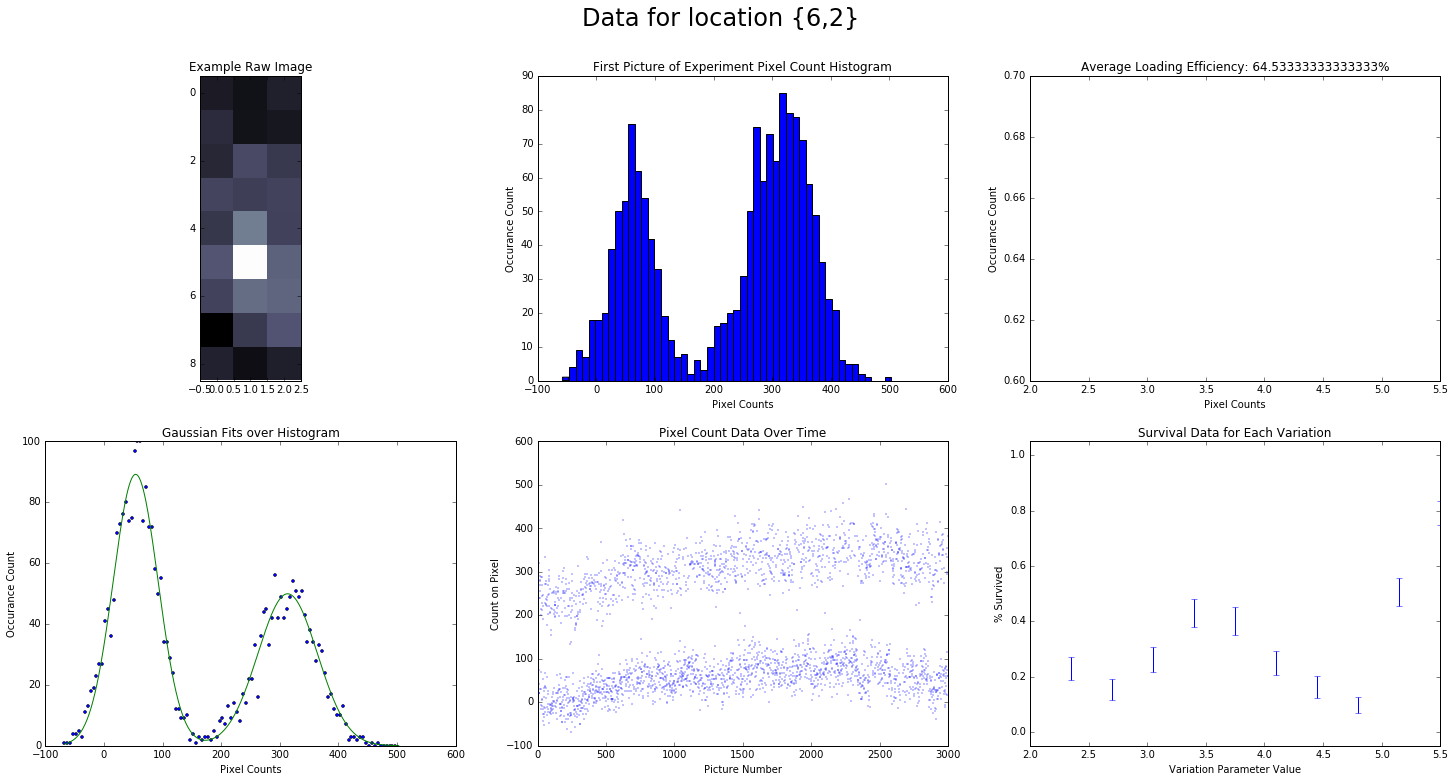

In [81]:
myFigure, ((plot11, plot12, plot13), (plot21, plot22, plot23)) = subplots(2, 3, figsize = (25,12))
myFigure.suptitle("Data for location {" + str(atomLocation[0] + 1) + "," + str(atomLocation[1] + 1) + "}", fontsize = 24);        
figObject = gcf()
figObject.canvas.set_window_title("{" + str(atomLocation[0] + 1) + "," + str(atomLocation[1] + 1) + "}")
# make an image
plot11.imshow(rawData[10], interpolation='none', cmap = get_cmap("bone"));
plot11.set_title("Example Raw Image")
# First counts histogram
plot12.hist(firstExperimentData, 50);
plot12.set_title("First Picture of Experiment Pixel Count Histogram");
plot12.set_ylabel("Occurance Count");
plot12.set_xlabel("Pixel Counts");
# plot loading probabilities
plot13.plot(fullCaptureData[:,0], fullCaptureData[:,1], linestyle = "none");
plot13.set_title("Average Loading Efficiency: " + str(atomCount / firstExperimentData.size * 100) + "%");
plot13.set_ylabel("Occurance Count");
plot13.set_xlabel("Pixel Counts");
# plot the fit on top of the histogram
plot21.plot(binCenters, binnedData, "o", markersize = 3);
fineXData = numpy.linspace(min(peakData),max(peakData),500);
plot21.plot(fineXData, doubleGaussian(fineXData,*gaussianFitVals))
plot21.set_title("Gaussian Fits over Histogram");
plot21.set_ylabel("Occurance Count");
plot21.set_xlabel("Pixel Counts");
plot22.plot(peakData, ".", markersize = 1);
plot22.set_title("Pixel Count Data Over Time");
plot22.set_ylabel("Count on Pixel");
plot22.set_xlabel("Picture Number");
plot23.errorbar(survivalData[:,0], survivalData[:,1], 
                          yerr=survivalData[:,2], linestyle = "none");
plot23.set_title("Survival Data for Each Variation")
plot23.set_ylabel("% Survived")
plot23.set_xlabel("Variation Parameter Value")
plot23.set_ylim([-0.05, 1.05])

### Export Data And Close

In [82]:
# 
fitsInfo.close()
#collatedData = [accumulations, peakData, key, survivalData, captureProbabilities, rawData, captureProbabilities];
outputName = dataRepositoryPath + date + "\\" + fileName + "_run" + str(runNumber) + "_well" + str(wellIndicator)+ ".tsv";
print(outputName)
with open(outputName, "w") as record_file:
    # accumulations is special since it's an integer.
    record_file.write(str(collatedData[0]) + "\n");
    ### Version for mathematica compatibility
    # Peak Data
    for peakInc in range(0, peakData.size):
        record_file.write(str(peakData[peakInc]) + "\t");
    record_file.write("\n");
    # key
    for keyInc in range(0, key.size-1):
        record_file.write(str(key[keyInc]) + "\t");
    record_file.write(str(key[key.size-1]));
    record_file.write("\n");
    # survival data
    survivalDimensions = survivalData.shape;
    for survivalPointsInc in range(0, survivalDimensions[0]-1):
        record_file.write(str("{{"));
        record_file.write(str(survivalData[survivalPointsInc][0]) + ", ");
        record_file.write(str(survivalData[survivalPointsInc][1]) + "}, ");
        record_file.write("ErrorBar[" + str(survivalData[survivalPointsInc][2]) + "]");
        record_file.write(str("}\t"));
    record_file.write(str("{{"));
    record_file.write(str(survivalData[survivalDimensions[0]-1][0]) + ", ");
    record_file.write(str(survivalData[survivalDimensions[0]-1][1]) + "}, ");
    record_file.write("ErrorBar[" + str(survivalData[survivalDimensions[0]-1][2]) + "]");
    record_file.write(str("}"));
    record_file.write("\n")
        # capture probabilities data
    for captureInc in range(0, captureArray.size):
        record_file.write(str(captureArray[captureInc]) + " ");
    record_file.write("\n");
    # raw data
    rawDataDimensions = rawData.shape;
    for pictureInc in range(0, rawDataDimensions[0]):
        record_file.write("{");
        for rowInc in range(0, rawDataDimensions[1]):
            record_file.write("{");
            for columnInc in range(0, rawDataDimensions[2]):
                record_file.write(str(rawData[pictureInc][rowInc][columnInc]) + " ")
            record_file.write("} ")
        record_file.write("}");
    record_file.write("\n");
    # full Capture Probabilitiy Data (capture probabilities with x values?)
    fullCaptureDataDimensions = fullCaptureData.shape;
    for variationInc in range(0, fullCaptureDataDimensions[0]):
        record_file.write("{" + str(fullCaptureData[variationInc][0]) + ", "
                          + str(fullCaptureData[variationInc][1]) + "} ");
    
    # sensible version
    # for dataInc in range(1,len(collatedData)):
        
        #record_file.write(str(collatedData[dataInc][0:len(collatedData[dataInc])]) + "\n");
        

\\andor\share\Data and documents\Data repository\160618\Ramsey_Piezo_Scan_Top_Y_run17_well6.tsv
